In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/training_sectiune/tot.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
df_comp = df.sample(50) # un numar de valori random sa vedem acuratetea
#df.sample(5)
#df.shape
df = df.sample(int(len(df)*(100/100)))
print(df.shape)

(36573, 11)


In [3]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() 
# #df = scaler.fit_transform(df)

In [4]:
df.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df.shape

Null values in dataset are 0


(36573, 11)

In [5]:
df_comp.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df_comp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_comp.dropna(inplace = True)
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df_comp.shape

Null values in dataset are 0


(50, 11)

In [6]:
from sklearn.model_selection import train_test_split


x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]



x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

#x_comp_train, x_comp_test, y_comp_train, y_comp_test = train_test_split(x_comp, y_comp, test_size=.2)

In [7]:
batch_size= 2000
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size)

#ds_comp_train = tf.data.Dataset.from_tensor_slices((x_comp_train,y_comp_train)).batch(batch_size)
#ds_comp_test = tf.data.Dataset.from_tensor_slices((x_comp,y_comp)).batch(batch_size)

Metal device set to: Apple M1


2022-06-11 20:44:45.517039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-11 20:44:45.517142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
#df['Freq 1    f1 [Hz]'] = df['Freq 1    f1 [Hz]'].astype(float, errors = 'raise')
df.dtypes

Pozitie            float64
Severitate def     float64
Severitate inc.    float64
Mod 1              float64
Mod 2              float64
Mod 3              float64
Mod 4              float64
Mod 5              float64
Mod 6              float64
Mod 7              float64
Mod 8              float64
dtype: object

In [9]:
f = ltn.Function.MLP(input_shapes=[8],output_shape=[3],hidden_layer_sizes=(100,100,50))

In [10]:
eq = ltn.Predicate.Lambda(
    lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    #lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

In [11]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [12]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

In [13]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.97138


2022-06-11 20:44:46.205725: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-11 20:44:46.205776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [14]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [16]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [17]:
EPOCHS = 2000

modelul = train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="testtest.csv",
    track_metrics=1
)

2022-06-11 20:44:46.396614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 20:44:46.881695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 20:44:47.052316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-11 20:44:47.156325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.9844, test_sat: 0.9862, train_accuracy: 0.1832, test_accuracy: 0.1595
Epoch 1, train_sat: 0.9875, test_sat: 0.9884, train_accuracy: 0.1456, test_accuracy: 0.1342
Epoch 2, train_sat: 0.9883, test_sat: 0.9885, train_accuracy: 0.1357, test_accuracy: 0.1328
Epoch 3, train_sat: 0.9886, test_sat: 0.9885, train_accuracy: 0.1322, test_accuracy: 0.1329
Epoch 4, train_sat: 0.9886, test_sat: 0.9886, train_accuracy: 0.1316, test_accuracy: 0.1316
Epoch 5, train_sat: 0.9887, test_sat: 0.9887, train_accuracy: 0.1308, test_accuracy: 0.1309
Epoch 6, train_sat: 0.9888, test_sat: 0.9890, train_accuracy: 0.1291, test_accuracy: 0.1275
Epoch 7, train_sat: 0.9892, test_sat: 0.9894, train_accuracy: 0.1252, test_accuracy: 0.1226
Epoch 8, train_sat: 0.9895, test_sat: 0.9893, train_accuracy: 0.1211, test_accuracy: 0.1234
Epoch 9, train_sat: 0.9897, test_sat: 0.9899, train_accuracy: 0.1197, test_accuracy: 0.1160
Epoch 10, train_sat: 0.9900, test_sat: 0.9902, train_accuracy: 0.1151, test_accu

In [18]:
import seaborn as sns
sns.set(font_scale=1.2)

/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


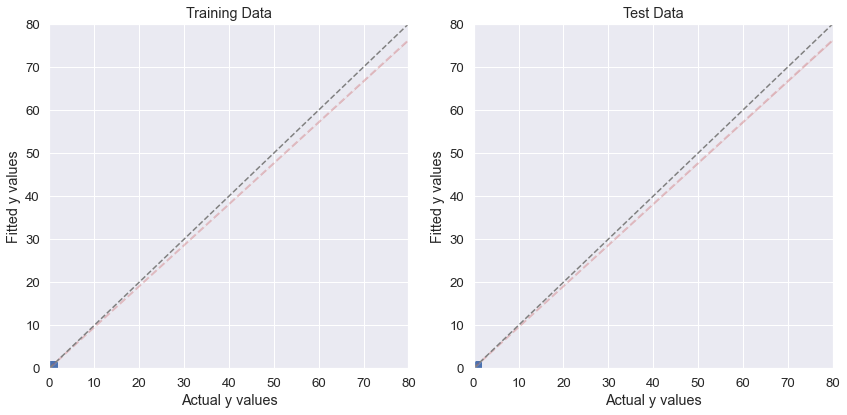

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
plt.savefig("LTN_regresie_1.pdf")

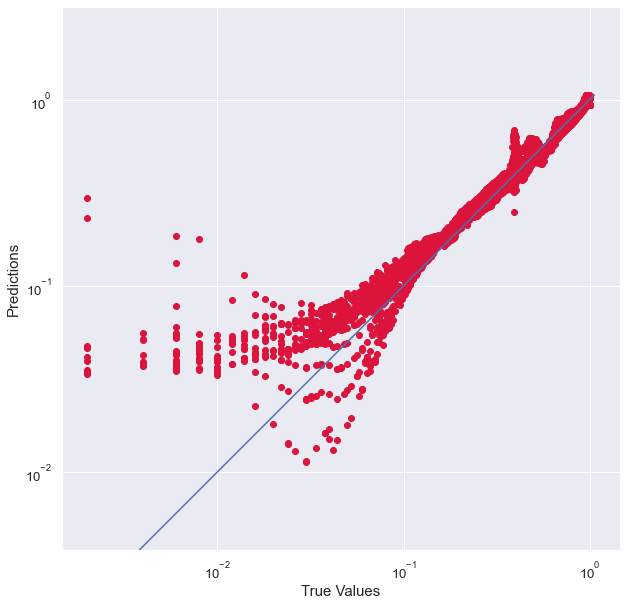

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(df['y_true'], df['y_pred'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['y_pred']), max(df['y_true']))
p2 = min(min(df['y_pred']), min(df['y_true']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig("LTN_regresie_2")
plt.show()

In [21]:
# figure, axis = plt.subplots(figsize=(12,8))
# x_ax = range(51)
# axis.plot(x_ax, data['y_true'].tail(50), label="Pozitie", color='c')
# axis.plot(x_ax, data['y_pred'].tail(50), label="Pozitie-pred", color='b')
# axis.legend()


# plt.savefig('test.pdf')  
# plt.show()

In [22]:
# fig, axs = plt.subplots(1,2,figsize=(12,6))
# ax = axs[0]
# data = {'y_pred':[],'y_true':[]}
# for x,y in ds_comp_train:
#     data['y_pred'].extend(f.model(x)[:,0].numpy())
#     data['y_true'].extend(y[:,0].numpy())
# df = pd.DataFrame(data,columns=['y_pred','y_true'])
# ax.set_xlim(0,80)
# ax.set_ylim(0,80)
# sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
#             scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
# ax.plot([0,100],[0,100],color="gray",linestyle="--")
# ax.set_xlabel("Actual y values")
# ax.set_ylabel("Fitted y values")
# ax.set_title("Training Data")

# # ax = axs[1]
# data = {'y_pred':[],'y_true':[]}
# for x,y in ds_comp_test:
#     data['y_pred'].extend(f.model(x)[:,0].numpy())
#     data['y_true'].extend(y[:,0].numpy())
# df = pd.DataFrame(data,columns=['y_pred','y_true'])
# ax.set_ylim(0,80)
# ax.set_xlim(0,80)
# sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
#             scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
# ax.plot([0,100],[0,100],color="gray",linestyle="--")
# ax.set_xlabel("Actual y values")
# ax.set_ylabel("Fitted y values")
# ax.set_title("Test Data")
# plt.tight_layout()
# plt.savefig("LTN_regresie_1.pdf")

In [23]:
# figure, axis = plt.subplots(figsize=(12,8))
# x_ax = range(50)
# axis.plot(x_ax, data['y_true'], label="Pozitie", color='c')
# axis.plot(x_ax, data['y_pred'], label="Pozitie-pred", color='b')
# axis.legend()


# plt.savefig('test_general.pdf')  
# plt.show()

In [24]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/training_sectiune/tot.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]
batch_size= 32
ds_test = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size)

data = {'y_pred':[],'y_true':[],'def':[],'inc':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
    data['def'].extend(y[:,0].numpy())
    data['inc'].extend(y[:,1].numpy())
data_plot = pd.DataFrame(data,columns=['y_pred','y_true','def','inc'])
#'Severitate def', 'Severitate inc.'

In [25]:
data_plot.head(4)

,y_pred,y_true,def,inc
0,0.805546,0.824,0.002141,0.000567
1,0.597994,0.616,0.020444,0.001020
2,0.559043,0.596,0.007105,0.001593
3,0.951424,0.924,0.001191,0.000567


In [26]:
data_plot.shape

(36573, 4)

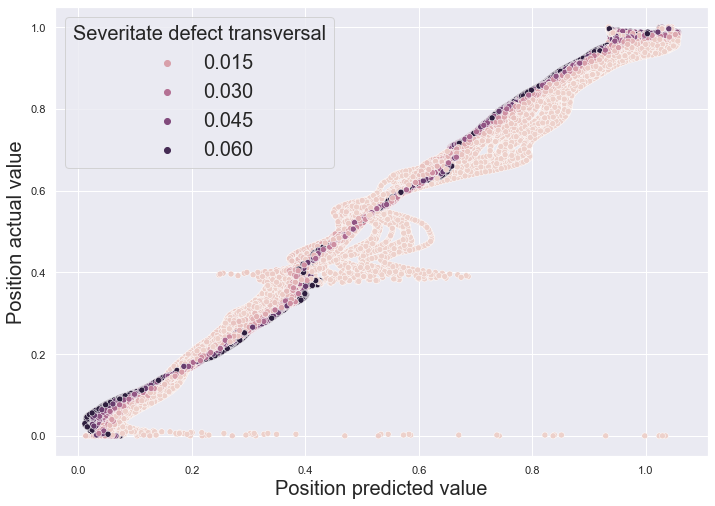

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(data=data_plot, x="y_pred", y="y_true", hue="def")
plt.legend(title = 'Severitate defect transversal', fontsize='20', title_fontsize='20')
plt.xlabel("Position predicted value", size=20)
plt.ylabel("Position actual value", size=20)
plt.savefig("def.png")

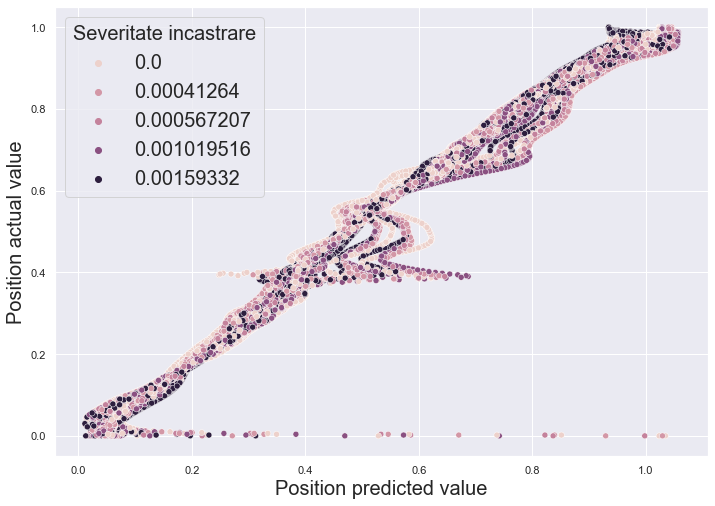

In [28]:
sns.scatterplot(data=data_plot, x="y_pred", y="y_true", hue="inc")
plt.legend(title = 'Severitate incastrare', fontsize='20', title_fontsize='20')
plt.xlabel("Position predicted value", size=20)
plt.ylabel("Position actual value", size=20)
plt.savefig("inc.png")

In [29]:
data_plot['def'].unique

<bound method Series.unique of 0        0.002141
1        0.020444
2        0.007105
3        0.001191
4        0.001191
           ...   
36568    0.002141
36569    0.051453
36570    0.016030
36571    0.032690
36572    0.051453
Name: def, Length: 36573, dtype: float64>

In [30]:
dif = abs( data_plot["y_pred"] - data_plot["y_true"])

In [31]:
index = -1
for i in dif:
    index+=1
    if i>4:
        print(i)
        print(index)

<StemContainer object of 3 artists>

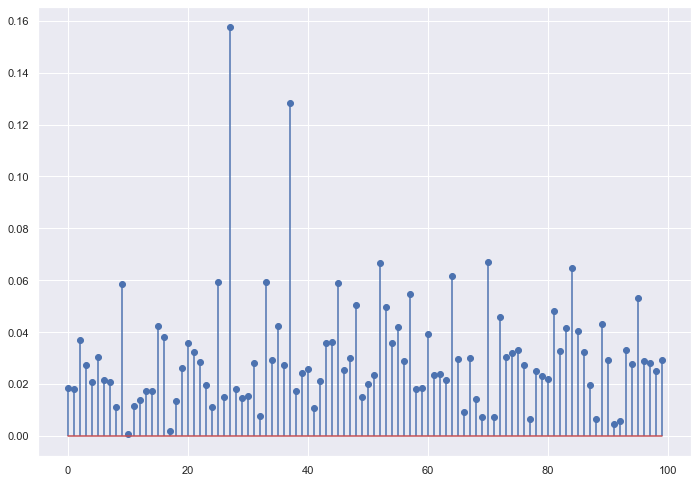

In [32]:
plt.stem(dif.head(100))

In [33]:
data_plot.head(100).corr()

,y_pred,y_true,def,inc
y_pred,1.000000,0.991949,0.004351,-0.031899
y_true,0.991949,1.000000,0.020202,-0.013815
def,0.004351,0.020202,1.000000,0.038733
inc,-0.031899,-0.013815,0.038733,1.000000


In [34]:
index = -1
for i in dif.head(100):
    index+=1
    if i>0.1:
        print(i)
        print(index)

0.15751796197891238
27
0.12813477134704587
37


In [35]:
data_plot.iloc[47]

y_pred    0.505824
y_true    0.536000
def       0.032690
inc       0.000567
Name: 47, dtype: float64

In [36]:
#severitatea def afecteaza cel mai mult, cand aceasta creste modelul prezice mai bine

In [37]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/date_test_corectate.csv", on_bad_lines='skip')

In [38]:
df = df.sample(frac=1) #shuffle
x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]
batch_size= 32
ds_test = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size)

data = {'y_pred':[],'y_true':[],'def':[],'inc':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
    data['def'].extend(y[:,0].numpy())
    data['inc'].extend(y[:,1].numpy())
data_plot = pd.DataFrame(data,columns=['y_pred','y_true','def','inc'])
#'Severitate def', 'Severitate inc.'

In [39]:
dif = abs( data_plot["y_pred"] - data_plot["y_true"])

<StemContainer object of 3 artists>

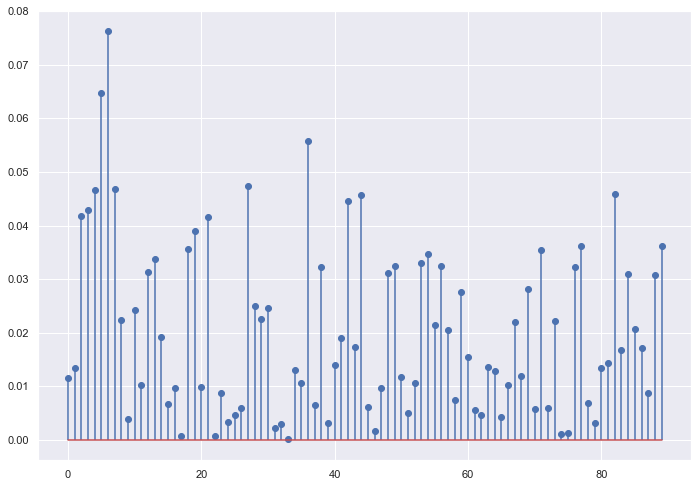

In [40]:
plt.stem(dif)

In [43]:
index = -1
for i in dif:
    index+=1
    if i>0.07:
        print(i)
        print(index)

0.07627153158187872
6


In [44]:
data_plot.iloc[6]

y_pred    0.483728
y_true    0.560000
def       0.003346
inc       0.000000
Name: 6, dtype: float64